# Helmholtz Equation on the Semi Disk

In [1]:
using Gmsh

using CairoMakie
using GeometryBasics

CairoMakie.activate!(type = "svg")

## Section 1:/ Introduction 
Create the geometry shown in the figure below, parameterized with $a = 0.01\,\mathrm{m}$ and outer radius $R = 0.133\,\mathrm{m}$. Ensure that the mesh is finer at the transducer, and that the boundaries have proper labels.
<img src="exercises/semicircle_radiation_domain.png" alt="Domain" width="300"/>
The geometry is used in the paper _Isogeometric simulation of acoustic radiation_ by Victoria Hernández, et al. (https://arxiv.org/abs/2111.02546)

## Section 2:/ Parameters for Geometry Definition

In [2]:
R = 0.133; # Radius of simulation domain
a = 0.01;  # Transducer aperture: 2*a

mshd_R = R / 5; # Mesh density at domain boundary
mshd_a = a / 5; # Mesh density at transducer aperture

## Section 3:/ Generate Mesh and Geometry using Gmsh

In [4]:
gmsh.initialize()

gmsh.model.add("semicircle")
geo = gmsh.model.geo;

# Points
geo.addPoint(0, 0, 0, mshd_a, 1)  # Semicircle boundary midpoint

geo.addPoint(-R, 0, 0, mshd_R, 2) # Boundary left
geo.addPoint(-a, 0, 0, mshd_a, 3) # Transducer aperture left
geo.addPoint(a, 0, 0, mshd_a, 4)  # Transducer aperture right
geo.addPoint(R, 0, 0, mshd_R, 5)  # Boundary right

# Lines
geo.addLine(2, 3, 1)
geo.addLine(3, 4, 2)
geo.addLine(4, 5, 3)
geo.addCircleArc(5, 1, 2, 4)

# Surfaces
geo.addCurveLoop([1, 2, 3, 4], 1)
geo.addPlaneSurface([1], 1)

# Physics
geo.addPhysicalGroup(2, [1], 1)

geo.addPhysicalGroup(1, [2], 1)
geo.addPhysicalGroup(1, [1, 3], 2)
geo.addPhysicalGroup(1, [4], 3)

gmsh.model.setPhysicalName(2, 1, "Omega")
gmsh.model.setPhysicalName(1, 1, "Gamma_D")
gmsh.model.setPhysicalName(1, 2, "Gamma_N")
gmsh.model.setPhysicalName(1, 3, "Gamma_R")

# Generate mesh
geo.synchronize();
gmsh.model.mesh.generate(2)

gmsh.write("gmsh-output/semicircle_radiation.msh")

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Circle)
Info    : Done meshing 1D (Wall 0.00318246s, CPU 0.002534s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00676375s, CPU 0.003738s)
Info    : 228 nodes 457 elements
Info    : Writing 'gmsh-output/semicircle_radiation.msh'...
Info    : Done writing 'gmsh-output/semicircle_radiation.msh'


## Section 4:/ Visualize Mesh using Gmsh GUI 

In [5]:
gmsh.fltk.run()

-------------------------------------------------------
Version       : 4.10.2
License       : GNU General Public License
Build OS      : MacOSX-sdk
Build date    : 19700101
Build host    : amdci7
Build options : 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blossom Cairo DIntegration Dlopen DomHex Eigen[contrib] Fltk GMP Gmm[contrib] Hxt Jpeg Kbipack MathEx[contrib] Mesh Metis[contrib] Mmg Mpeg Netgen ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OpenMP OptHom Parser Plugins Png Post QuadMeshingTools QuadTri Solver TetGen/BR Voro++[contrib] WinslowUntangler Zlib
FLTK version  : 1.3.8
OCC version   : 7.6.2
Packaged by   : root
Web site      : https://gmsh.info
Issue tracker : https://gitlab.onelab.info/gmsh/gmsh/issues
-------------------------------------------------------


## Section 5:/ Visualize Mesh using Makie 

In [6]:
# Obtain a GeometryBasics.Mesh object suitable for plotting with Makie
function get_node_mesh()
    node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
    nNode = length(node_ids)

    eType, eTag, eConn = gmsh.model.mesh.getElements(2);
    nEl = length(eTag[1])

    points   = zeros(Point2f, nNode);          # Array of vertex coordinates (x,y)
    trif     = zeros(TriangleFace{Int}, nEl);  # Array of triangular faces (n1, n2, n3)
    
    for n in 1:nNode
        points[node_ids[n]] = Point2f(node_coord[3*(n-1) + 1], node_coord[3*(n-1) + 2])
    end
    for e in 1:nEl
        trif[e] = (eConn[1][3*(e-1)+1], eConn[1][3*(e-1)+2], eConn[1][3*(e-1)+3])
    end
    
    msh = GeometryBasics.Mesh(points, trif);
    return msh;
end

get_node_mesh (generic function with 1 method)

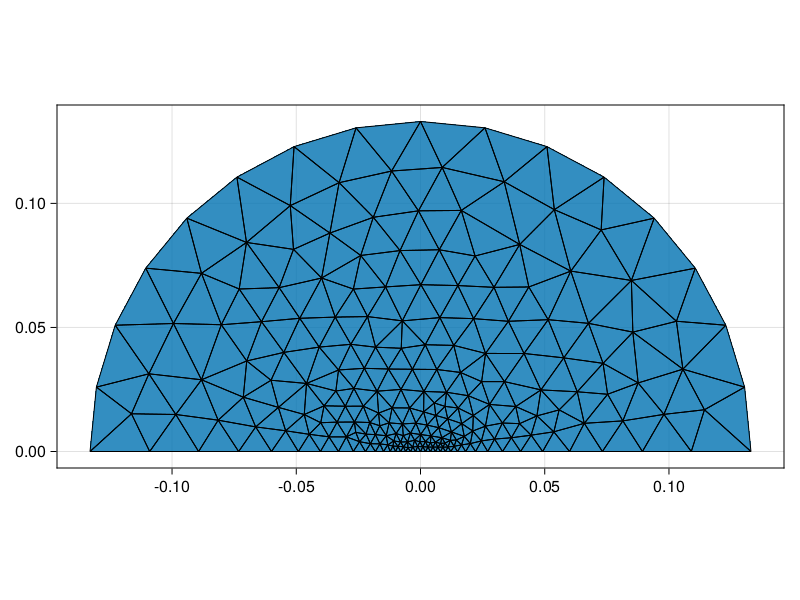

In [7]:
msh = get_node_mesh()

f, ax, pl = mesh(msh, shading = false)
wireframe!(ax, msh, color=(:black), linewidth=1, transparency=false)
ax.aspect = AxisAspect(2)
current_figure()

In [8]:
save("exercises/semicircle_radiation.svg", f)

LoadError: SystemError: opening file "/Users/djplahaye/mijn_onderwijs/finite_element_electrical_engineering/public/project-based-assignment/exercises/semicircle_radiation.svg": No such file or directory

![Mesh](exercises/semicircle_radiation.svg)

## Section 6:/ Solve Helmholz Equation using Gridap package 

In [9]:
using Gridap
using Gridap.Algebra;
using Gridap.FESpaces
using Gridap.ReferenceFEs
using Gridap.Arrays
using Gridap.Geometry
using Gridap.Fields
using Gridap.CellData

using GridapGmsh

In [14]:
# Load mesh
model = GmshDiscreteModel("gmsh-output/semicircle_radiation.msh")
Ω = Triangulation(model)

# Define Lagrangian reference element
order = 2;
reffe = ReferenceFE(lagrangian, Float64, order)
dΩ = Measure(Ω, 2*order)

neumanntags = ["Gamma_N"]
ΓN = BoundaryTriangulation(model,tags=neumanntags)
dΓN = Measure(ΓN,order)

sommertags = ["Gamma_R"]
ΓR = BoundaryTriangulation(model,tags=sommertags)
dΓR = Measure(ΓR,order)

# Construct Lagrangian test space with dirichlet condition on the right boundary node
V = TestFESpace(model, reffe, conformity = :H1, dirichlet_tags = ["Gamma_D"], vector_type = Vector{ComplexF64})
U = TrialFESpace(V, [1]) 

Info    : Reading 'gmsh-output/semicircle_radiation.msh'...
Info    : 10 entities
Info    : 227 nodes
Info    : 452 elements
Info    : Done reading 'gmsh-output/semicircle_radiation.msh'


TrialFESpace()

In [23]:
# Define the weak form (bilinear and linear terms)
kwav = 10.0 
fsource(x) = 0.
a_bilin(u,v) = ∫( ∇(v)⋅∇(u) - (kwav^2*(v*u)))*dΩ + ∫(1im*kwav*u*v)*dΓR
b_lin(v) = ∫( v*fsource )*dΩ 
op = AffineFEOperator(a_bilin,b_lin, U, V)
uh = solve(op)

SingleFieldFEFunction():
 num_cells: 400
 DomainStyle: ReferenceDomain()
 Triangulation: BodyFittedTriangulation()
 Triangulation id: 575576965363664714

In [25]:
writevtk(Ω, "simulation-output/output.vtu", cellfields=["uh_real"=>real(uh),"uh_imag"=>imag(uh)])

(["simulation-output/output.vtu"],)

![Result: Real Part of Computed solution](images/helmholtz_real_uh.png)

![Result: Imaginary Part of Computed solution](images/helmholtz_imag_uh.png)